In [41]:
import sys
import warnings
warnings.filterwarnings(action='ignore')
import collections
from IPython.display import display
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager, rc
import pandas as pd
import mglearn
from sklearn.model_selection import train_test_split

mpl.rcParams['axes.unicode_minus'] = False
font_fname = '/Users/seongdae/Library/Fonts/NanumGothicLight.ttf'
font_name = font_manager.FontProperties(fname=font_fname).get_name()

rc('font', family=font_name)
# size, family
print ('font size : '+str(plt.rcParams['font.size']) )
print ('font family : '+str(plt.rcParams['font.family']) )
# import default setting
print('python version : {0}\npandas version : {1}\nmatplotlib version : {2}\nnumpy version : {3}\n'
.format(sys.version, pd.__version__, mpl.__version__, np.__version__))

font size : 10.0
font family : ['NanumGothic']
python version : 3.7.6 (v3.7.6:43364a7ae0, Dec 18 2019, 14:18:50) 
[Clang 6.0 (clang-600.0.57)]
pandas version : 0.25.3
matplotlib version : 3.1.2
numpy version : 1.18.1



# 분류 예측의 불확실성 추정

In [42]:
# scikit-learn에서 많이 사용하는 인터페이스 중 하나는 분류기에 예측의 불확실성을 추가할 수 있는 기능
# 어떤 테스트 포인트에 대해 분류기가 예측한 클래스가 무엇인지 뿐만 아니라, 정확한 클래스임을 얼마나 확신하는지가 중요할 떄가 있음
    # 얼마나 정확한_올바른의미를가진 예측을 한 것인가
# 실제 application에서는 오류의 종류에 따라 전혀 다른 결과를 만듬
    # 의료 예측 application에서는 거짓 양성 예측은 환자가 추가 진료를 요구하지만
    # 거짓 음성 예측은 심각한 질병을 치료하지 못하게 할 수 있음

# scikit-learn에서는 decision_function, predict_proba 함수를 이용할 수 있음, 측정을 위해, 결정함수..?

## 결정함수

In [57]:
# GradientBoostingClassifier 분류기의 decision_funciton, predict_proba 예제
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles

X, y = make_circles(noise=.25, factor=.5, random_state=1)
y_named = np.array(['blue','red'])[y] # labeling 0, 1 -> blue, red

# 다수의 배열을 train_test_split 함수에 넣을 수 있음, 훈련 테스트로 나뉘는 방식은 동일
X_train, X_test, y_train_named, y_test_named, y_train, y_test = train_test_split(X, y_named, y, random_state=0)

# 그래디언트 부스팅
gbrt = GradientBoostingClassifier(random_state=0).fit(X_train, y_train_named)

In [58]:
print('X_test shape : ',X_test.shape)
print('결정함수 결과 형태 : ', gbrt.decision_function(X_test).shape)
    # 반환값 : (n_smaples, ) 각 샘플이 하나의 실수 값을 반환함
# 결정함수 결과 중 앞부분 일부 확인
print('결정함수 : \n', gbrt.decision_function(X_test)[:6])
# 값 양성 : 클래스 1에 속한다고 믿는 정도, 음성 : 클래스 0(다른 클래스)를 의미

X_test shape :  (25, 2)
결정함수 결과 형태 :  (25,)
결정함수 : 
 [ 4.13592629 -1.7016989  -3.95106099 -3.62599351  4.28986668  3.66166106]


In [59]:
# 결정 함수의 부호를 보고 예측 결과를 알 수 있음

print('임계치(0)와 결정 함수 결과 비교 : \n', gbrt.decision_function(X_test) > 0)
print('예측 : \n', gbrt.predict(X_test))
# 음수 -> blue, 양수 -> red

임계치(0)와 결정 함수 결과 비교 : 
 [ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
예측 : 
 ['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


In [60]:
# 이진분류에서 음성 클래스는 항상 classes_속성의 첫번째 원소이고, 양성 클래스는 classes_속성의 두번째 원소
# 그러므로, predict 함수의 결과를 완전히 재현하려면 classes 속성 사용

# boolean 값들을 0,1 변환
greater_zero = (gbrt.decision_function(X_test)>0).astype(int)

# classes_ 에 인덱스로 사용
pred = gbrt.classes_[greater_zero]

# pred값과 gbrt,predict 비교
print('같은가? ',np.all(pred == gbrt.predict(X_test)))

같은가?  True


In [61]:
# 결정함수의 범위는 데이터와 모델 파라미터에 따라 달라짐
decision_function = gbrt.decision_function(X_test)
print('결정 함수 최솟값 : {:.4f}\n결정함수 최댓값 : {:.4f}'.format(np.min(decision_function), np.max(decision_function)))

# 출력범위는 임의의 값이기 때문에, 왜 이런값이 나오는지 이해하기 힘듬

결정 함수 최솟값 : -7.6910
결정함수 최댓값 : 4.2899


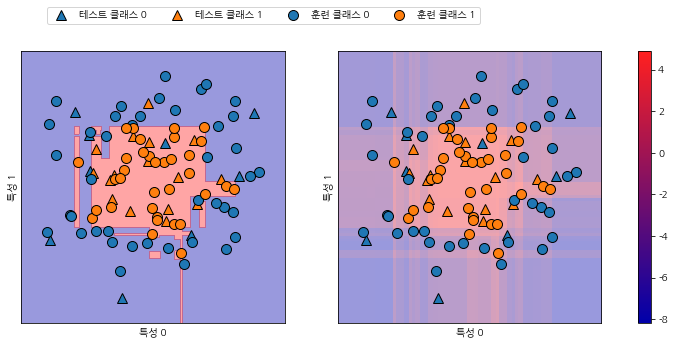

In [62]:
# 2차원 평면의 모든 점에 대해 decision_function 의 값을 색으로 표현, 결정 경계와 함께 그래프로 표현
# train 원, test 삼각형
fig, axes = plt.subplots(1, 2, figsize = (13, 5))

mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
score_img = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    # 훈련 포인트와 테스트 포인트 그리기
    mglearn.discrete_scatter(X_test[:,0], X_test[:,1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:,0], X_train[:,1], y_train, markers='o', ax=ax)
    ax.set_xlabel('특성 0')
    ax.set_ylabel('특성 1')
cbar = plt.colorbar(score_img, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(['테스트 클래스 0', '테스트 클래스 1', '훈련 클래스 0', '훈련 클래스 1'], ncol=4, loc=(.1, 1.1))

In [49]:
# 좌_ 결정 경계, 우_ 결정 함수
# 예측한 결과 뿐 아니라, 얼마나 확신하는지 알면 추가정보를 얻게됨
# 그러나 결정함수 그래프에서 구 클래스 사이의 경계를 구분하기는 어려움


## 예측 확률

In [65]:
# predict_proba의 출력은 각 클래스에 대한 확률
# decision_function의 출력보다 이해하기 더 쉬움

# 이 값의 크기(predict_proba)의 크기는 이진분류에서 항상 (n_samples, 2)임
print('예측 확률 값의 형태 : ', gbrt.predict_proba(X_test).shape)

# 각 행의 첫번째 원소는 첫번째 클래스의 예측 확률, 두번째 원소는 두번째 클래스의 예측 확률
# 확률이기때문에, predict_proba의 출력은 항상 0과 1 사이이며, 두 클래스의 대한 확률의 합은 항상 1임

예측 확률 값의 형태 :  (25, 2)


In [69]:
# predict_proba 의 앞부분 일부 확인
print('예측 확률 : \n', gbrt.predict_proba(X_test[:6]))

# 두 클래스의 확률 합은 1, 두 클래스중 하나는 반드시 50%이상의 값을 가지고 있음, 만약 정말 50.000 50.00 이라면 랜덤하게 하나를 선택함
# 그 클래스가 예측값이 됨

예측 확률 : 
 [[0.01573626 0.98426374]
 [0.84575649 0.15424351]
 [0.98112869 0.01887131]
 [0.97406775 0.02593225]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]
